<a href="https://colab.research.google.com/github/d-hetalpatel/news-bias-detection/blob/main/news_bias_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch transformers sentence-transformers scikit-learn pandas seaborn matplotlib


In [2]:
# Install missing packages
# !pip install torch transformers sentence-transformers scikit-learn pandas seaborn matplotlib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

In [3]:
csv_path ="/content/news_headlines.csv"
df = pd.read_csv(csv_path)#pd.DataFrame(data, columns=["headline", "label"])
df


,headline,label
0,Government must invest in renewable energy,left
1,City hosts annual marathon,neutral
2,School board schedules meeting,neutral
3,Funding education should be top priority,left
4,Council approves new park project,neutral
...,...,...
1495,School board schedules meeting,neutral
1496,Government regulation stifles growth,right
1497,Support for healthcare reform grows,left
1498,City hosts annual marathon,neutral


In [4]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
df


,headline,label,label_encoded
0,Government must invest in renewable energy,left,0
1,City hosts annual marathon,neutral,1
2,School board schedules meeting,neutral,1
3,Funding education should be top priority,left,0
4,Council approves new park project,neutral,1
...,...,...,...
1495,School board schedules meeting,neutral,1
1496,Government regulation stifles growth,right,2
1497,Support for healthcare reform grows,left,0
1498,City hosts annual marathon,neutral,1


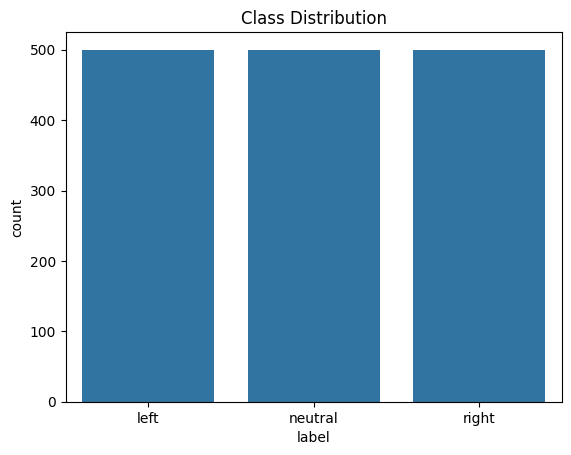

In [5]:
sns.countplot(x='label', data=df)
plt.title("Class Distribution")
plt.show()


In [6]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenize headlines
encodings = tokenizer(df['headline'].tolist(), truncation=True, padding=True, max_length=32)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
#PyTorch Dataset Class
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = NewsDataset(encodings, df['label_encoded'].tolist())


In [8]:
#Load Pretrained Transformer for Classification
num_labels = len(df['label'].unique())
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
#Training
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=20
   # evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset
)

# Start training
trainer.train()

#manual evaluation
metrics = trainer.evaluate()
print(metrics)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss
20,1.093200
40,1.087100
60,1.069800
80,1.011600
100,0.895900
120,0.724700
140,0.539700
160,0.317200
180,0.156100
200,0.075300


{'eval_loss': 0.0006913283141329885, 'eval_runtime': 0.985, 'eval_samples_per_second': 1522.81, 'eval_steps_per_second': 190.859, 'epoch': 5.0}


In [12]:
model.eval()
model.to(device)

y_true = df['label_encoded'].tolist()
y_pred = []

for headline in df['headline']:
    inputs = tokenizer(
        headline,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=32
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    pred = torch.argmax(logits, dim=1).cpu().item()
    y_pred.append(pred)

In [13]:
#Inference on New Headlines
def predict(headline):
    model.eval()
    model.to(device)

    inputs = tokenizer(
        headline,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=32
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    pred_id = torch.argmax(logits, dim=1).cpu().item()
    return le.inverse_transform([pred_id])[0]

# Test
test_headlines = [
    "Government increases investment in renewable energy",
    "Local park gets new playground",
    "Taxes on businesses are too high"
]

for h in test_headlines:
    print(f"Headline: '{h}' → Predicted Bias: {predict(h)}")


Headline: 'Government increases investment in renewable energy' → Predicted Bias: left
Headline: 'Local park gets new playground' → Predicted Bias: neutral
Headline: 'Taxes on businesses are too high' → Predicted Bias: right


In [14]:
model.save_pretrained(
    "models/news_bias_model",
    safe_serialization=False
)
tokenizer.save_pretrained("models/news_bias_model")


('models/news_bias_model/tokenizer_config.json',
 'models/news_bias_model/special_tokens_map.json',
 'models/news_bias_model/vocab.txt',
 'models/news_bias_model/added_tokens.json',
 'models/news_bias_model/tokenizer.json')

In [19]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!cp -r models/news_bias_model /content/drive/MyDrive/
